In [1]:
import sys
sys.path.append('library');

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    width_shift_range= 0.07,
    height_shift_range= 0.07,
    horizontal_flip=True,
    shear_range=1.25,
    zoom_range = [0.75, 1.25],
    validation_split=0.25 # 25%
)

batch_size=32;
basedir='/mnt/boveda/DATASETs/PATIENT-IMAGES/patient_people';# tow inside directories
data_gen_entrenamiento = datagen.flow_from_directory(   basedir, 
                                                        target_size=(224,224),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset='training'
                                                        );
data_gen_validacion = datagen.flow_from_directory(      basedir, 
                                                        target_size=(224,224),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset='validation'
                                                        );



/home/fernando/.local/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Found 648 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


# Mostrando algunos datos


N: 21
batch_size: 32


/usr/lib/python3/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


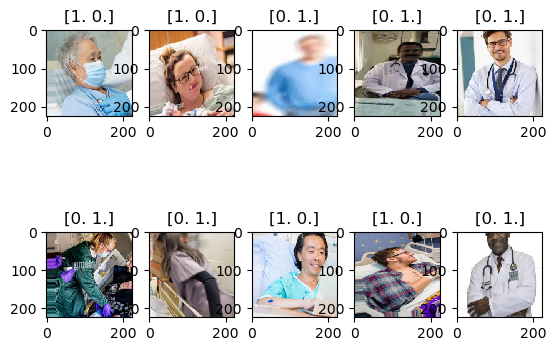

In [2]:
# Number of batchs
number_of_batchs=len(data_gen_entrenamiento);
# tuple-2 : data_gen_entrenamiento[n]=(image,label)
print("N:",number_of_batchs)
print("batch_size:",batch_size)
for imagen, etiqueta in data_gen_entrenamiento:
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.title(etiqueta[i])
        plt.imshow(imagen[i])
    break;
plt.show()


# Creando el modelo de transfer learning usando keras

In [3]:

import tensorflow as tf
import lib_model_patient_people as mpp

checkpoint_path='modelo.h5';
modelo=mpp.load_model_patient_people(checkpoint_path);
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# Compilando y entrenando

In [4]:

# compilando
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create a callback that saves the model's weights

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy', 
                                                 save_best_only=True,
                                                 verbose=1)


EPOCAS=100;
historical = modelo.fit(
    data_gen_entrenamiento, 
    steps_per_epoch=int(648/batch_size),
    epochs=EPOCAS, 
    validation_data=data_gen_validacion,
    callbacks=[cp_callback]
)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9042
Epoch 1: val_accuracy improved from -inf to 0.87383, saving model to modelo.h5
20/20 [==============================] - 21s 974ms/step - loss: 0.2307 - accuracy: 0.9042 - val_loss: 0.3507 - val_accuracy: 0.8738
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9237
Epoch 2: val_accuracy did not improve from 0.87383
20/20 [==============================] - 18s 898ms/step - loss: 0.1971 - accuracy: 0.9237 - val_loss: 0.3676 - val_accuracy: 0.8271
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9334
Epoch 3: val_accuracy improved from 0.87383 to 0.88318, saving model to modelo.h5
20/20 [==============================] - 18s 932ms/step - loss: 0.1758 - accuracy: 0.9334 - val_loss: 0.3319 - val_accuracy: 0.8832
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9334
Epoch 4: val

# Estadisticas

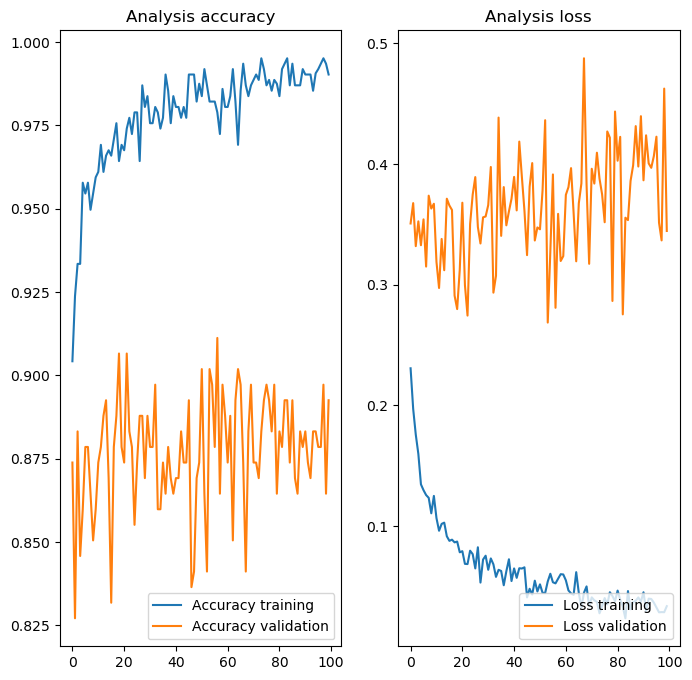

max_val_acc 0.9112149477005005


In [5]:
acc      = historical.history['accuracy'];
val_acc  = historical.history['val_accuracy'];
loss     = historical.history['loss'];
val_loss = historical.history['val_loss'];

rango_epocas=range(EPOCAS);

plt.figure(figsize=(8,8))
#
plt.subplot(1,2,1)
plt.plot(rango_epocas,    acc,label='Accuracy training')
plt.plot(rango_epocas,val_acc,label='Accuracy validation')
plt.legend(loc='lower right')
plt.title('Analysis accuracy')
#
plt.subplot(1,2,2)
plt.plot(rango_epocas,    loss,label='Loss training')
plt.plot(rango_epocas,val_loss,label='Loss validation')
plt.legend(loc='lower right')
plt.title('Analysis loss')
#
plt.show()

print('max_val_acc', np.max(val_acc))

import os
os.rename(checkpoint_path, 'modelo_acc'+str(int(np.max(val_acc)*100000))+'.h5')